# Recitation 1: Pytorch Basics Overview

**Note: please make a COPY of the notebook if you'll be making any changes or running any cells**

We'll be using pytorch for several coding assignments in this class. This tutorial covers:
* Setting up a training and evaluation loop
* Defining a data iterator, nn.Module, loss and evaluation functions, etc.
* Implementing a forward and a backward pass in custom torch autograd functions

We'll be using sentiment classification of IMDB reviews as our running example.

In [ ]:
!pip install -U torchtext==0.10.0
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.3 MB/s 
     |████████████████████████████████| 831.4 MB 2.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


## Tensors

PyTorch defines and uses Tensors for all of it's operations, which are very similar to numpy ndarrays. Like ndarrays, PyTorch tensors are also multidimensional arrays of data with a specified datatype. But pytorch tensors and operations defined in PyTorch over them let you easily transition to using GPUs or TPUs to speed up computation. And most importantly, PyTorch has autograd, which automatically constructs a computational graph making it easy to compute gradients for each tensor since most supported tensor operations come with gradient functions defined.

#### Creating Tensors

In [ ]:
# You can make a tensor directly from data
data = [[1., 2.], [3., 4.]]
x_data = torch.tensor(data)
print(x_data)
print(x_data.dtype)
print()

# Call tensor.numpy() to get a numpy array.
# (Note that this only works on detached cpu tensors, should be clear after autograd is explained)
print(x_data.numpy())

tensor([[1., 2.],
        [3., 4.]])
torch.float32

[[1. 2.]
 [3. 4.]]


In [ ]:
# You can also make a tensor from a numpy array
data = [[1., 2.], [3., 4.]]
np_data = np.asarray(data, dtype=np.float32)
x_data = torch.from_numpy(np_data)

print(x_data)
print(x_data.dtype)

# Note:
# While this method to construct arrays is very common,
# the np array and tensor share the same underlying memory.
# So, changing the ndarray would change the tensor and vice-versa.
np_data[0][0] = -1
print(x_data)

tensor([[1., 2.],
        [3., 4.]])
torch.float32
tensor([[-1.,  2.],
        [ 3.,  4.]])


In [ ]:
# A few other useful ways to initialize tensors with constant or random values

# Create an array of all ones:
print("torch.ones((2, 2, 2)) creates a (2, 2, 2) tensor of ones:\n", torch.ones((2, 2, 2)))
print()

# Create an array of all zeros:
print("torch.zeros((2, 2, 2)) creates a (2, 2, 2) tensor of zeros:\n", torch.zeros((2, 2, 2)))
print()

# Create an array of random floats ~ Unif[0, 1):
print("torch.rand((2, 2, 2)) creates a (2, 2, 2) tensor from the uniform distribution :\n", torch.rand((2, 2, 2)))
print()

torch.ones((2, 2, 2)) creates a (2, 2, 2) tensor of ones:
 tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])

torch.zeros((2, 2, 2)) creates a (2, 2, 2) tensor of zeros:
 tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

torch.rand((2, 2, 2)) creates a (2, 2, 2) tensor from the uniform distribution :
 tensor([[[0.1860, 0.3098],
         [0.8798, 0.7245]],

        [[0.9081, 0.5975],
         [0.3645, 0.6255]]])



### Tensor operations

In [ ]:
# clone() creates a copy of a tensor
x = torch.rand((2,))
x_clone = x.clone()

print(x, x_clone)
x_clone[0] = 0.

print(x, x_clone)

tensor([0.3243, 0.2187]) tensor([0.3243, 0.2187])
tensor([0.3243, 0.2187]) tensor([0.0000, 0.2187])


In [ ]:
# Standard numpy style slicing and indexing works, as well as standard arithmetic operations
x = torch.rand((4, 4))
print("x:", x)

print("Slice:\n", x[:, 1: 3])

print("\nElement-wise arithmetic ops:")

x = torch.ones((2, 2))
y = torch.ones((2, 2))
print("x:", x)
print("y:", y)
print("x + y:\n", x + y)
print("x - y:\n", x - y)
print("x * y:\n", x * y)
print("x / y:\n", x / y)

print("Matrix multiplication:")
print("x @ y", x @ y)


x: tensor([[0.9607, 0.0788, 0.5656, 0.3854],
        [0.4901, 0.7213, 0.9129, 0.7857],
        [0.7263, 0.8439, 0.0881, 0.5444],
        [0.8431, 0.9810, 0.5124, 0.7439]])
Slice:
 tensor([[0.0788, 0.5656],
        [0.7213, 0.9129],
        [0.8439, 0.0881],
        [0.9810, 0.5124]])

Element-wise arithmetic ops:
x: tensor([[1., 1.],
        [1., 1.]])
y: tensor([[1., 1.],
        [1., 1.]])
x + y:
 tensor([[2., 2.],
        [2., 2.]])
x - y:
 tensor([[0., 0.],
        [0., 0.]])
x * y:
 tensor([[1., 1.],
        [1., 1.]])
x / y:
 tensor([[1., 1.],
        [1., 1.]])
Matrix multiplication:
x @ y tensor([[2., 2.],
        [2., 2.]])


In [ ]:
# Use torch.cat to concatenate two tensors along an existing dimension

x = torch.zeros((2, 2))
y = torch.ones((2, 3))

print("torch.cat((x, y), dim=1):\n", torch.cat((x, y), dim=1))
print()

# Use torch.stack to stack tensors of equal dimension along a new axis

a = torch.zeros((2, 2))
b = torch.ones((2, 2))

stacked = torch.stack((a, b), dim=0)
print("stacked tensor:\n", stacked)
print("stacked tensor shape:\n", stacked.shape)

torch.cat((x, y), dim=1):
 tensor([[0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]])

stacked tensor:
 tensor([[[0., 0.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.]]])
stacked tensor shape:
 torch.Size([2, 2, 2])


Some other useful operations to read into from the pytorch documentation
- view (reshapes array, but only works on contiguous arrays: https://discuss.pytorch.org/t/difference-between-view-reshape-and-permute/54157)
- reshape
- transpose
- squeeze
- unsqueeze
- sum
- mean


##Building Computation Graphs with Tensors

In [ ]:
# Automatic differentiation is enabled on most pytorch operations, which get tracked through the computation graph
x = torch.rand((2, 2), requires_grad=True)
x

tensor([[0.9845, 0.8013],
        [0.4230, 0.2424]], requires_grad=True)

In [ ]:
# For example, the slice "operation" has it's own backward gradient function defined
x[1:2]

tensor([[0.4230, 0.2424]], grad_fn=<SliceBackward>)

In [ ]:
# Or the sum operation
x.sum()

tensor(2.4511, grad_fn=<SumBackward0>)

In [ ]:
# We can call a backward() pass on any pytorch scalar attached to a computation graph
x = torch.rand((2, 2), requires_grad=True)
print("x: ", x)

y = x * 2
print("y: ", y)

z = y[0]
print("z: ", z)

loss = z.sum()
print(loss)

x:  tensor([[0.9420, 0.2618],
        [0.5053, 0.0915]], requires_grad=True)
y:  tensor([[1.8840, 0.5237],
        [1.0106, 0.1830]], grad_fn=<MulBackward0>)
z:  tensor([1.8840, 0.5237], grad_fn=<SelectBackward>)
tensor(2.4076, grad_fn=<SumBackward0>)


In [ ]:
# Leaf variables in the computation graph (like x here) have a gradient attached
#  which is by default None
print(x.grad)

None


In [ ]:
# A .backward() call runs a backward pass through the computation graph and populates the .grad for leaf variables
loss.backward()

print(x.grad)

tensor([[2., 2.],
        [0., 0.]])


In [ ]:
# Non leaf variables do not have their .grad populated after a backward pass
#  If interested, look into "retain_graph" here: https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
print(y.grad)

None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from itertools import tee
import torch
import torch.nn as nn
from torch.autograd import Function
from torchtext.legacy import data
from torchtext.legacy import datasets
import numpy as np

## Neural Network *Construction*

Neural networks are usually defined by classes that inherit from the **nn.Module** class.

For each network, we define a **`forward`** function that is run in the forward pass through the network.

In Pytorch, **backpropagation** is done through automatic differentiation. It traverses backwards from the output, collecting gradients (derivatives of the error with respect to the parameters of the functions), and optimizes using gradient descent (or whichever optimization algorithm is chosen). Note that when you instantiate parameters that need to be updated, you should make sure that `requires_grad` is set to `True`. This signals to autograd that every operation on it should be tracked.

Below are several neural net modules we can use in our final architecture:

In [ ]:
# Basic multi-layer perceptron class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.linear_layer = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.output_layer(self.activation(self.linear_layer(x)))

In [ ]:
# Define a simple continuous bag-of-words encoder
class CBOWEncoder(nn.Module):
    def __init__(self, emb_size, vocab_size):
        super(CBOWEncoder, self).__init__()
        self.emb_size = emb_size  # the size of each embedding vector
        self.vocab_size = vocab_size  # size of the dictionary of embeddings
        self.embeddings = nn.Embedding(self.vocab_size, self.emb_size)
        self.pooling_layer = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        embedded_text = self.embeddings(x.text)
        embedded_text = embedded_text.permute(1, 2, 0)
        pooled_rep = self.pooling_layer(embedded_text)
        pooled_rep = pooled_rep.squeeze(-1)
        return pooled_rep

In [ ]:
# Define a simple LSTM Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size):
        super(LSTMEncoder, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(self.vocab_size, self.emb_size)
        self.lstm = nn.LSTM(self.emb_size, self.hidden_size, batch_first=False)
        self.pooling_layer = nn.AdaptiveMaxPool1d(1)
    
    def forward(self, x):
        embedded_text = self.embeddings(x.text)
        lstm_output, _ = self.lstm(embedded_text)
        lstm_output = lstm_output.permute(1, 2, 0)
        pooled_rep = self.pooling_layer(lstm_output)
        pooled_rep = pooled_rep.squeeze(-1)
        return pooled_rep

## Advanced: Under the hood of a Linear layer

Sometimes, we may want to add operations to `autograd` that is not already included in pytorch. To help you understand how we might do this, let's study how nn.Linear is implemented.

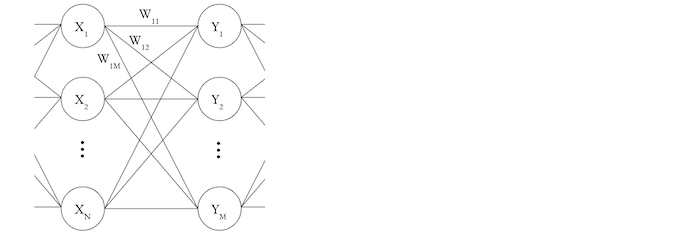

`Function`'s are what `autograd` uses to compute the results and gradients, and encode the operation history. When defining a new `Function`, we must define static methods `forward()` which performs the operation and `backward()` which computes the gradient formulas with respect to the arguments to the forward function.

**Forward pass**: For a linear layer, given an input $X \in \mathbb{R}^{N \times D}$ and weights $W \in \mathbb{R}^{D \times M}$, the forward pass computes the output $Y = XW$, where $Y \in \mathbb{R}^{N \times M}$. Note that a bias can be represented by adding an additional dimension to $X$ containing 1's, and a corresponding additional dimension to the weights.

<!-- For a linear layer, given an input $x \in \mathbb{R}^{D \times 1}$, weights $W \in \mathbb{R}^{D \times M}$, and bias $b \in \mathbb{R}^{M \times 1}$, the forward pass computes the output $y = W^Tx + b$, where $y \in \mathbb{R}^{M \times 1}$. -->

**Backward pass**: During the backward pass, we assume that the upstream gradient $\frac{\partial L}{\partial Y}$ has already been computed. Given this upstream gradient, we aim to calculate $\frac{\partial L}{\partial X}$ and $\frac{\partial L}{\partial W}$. Applying the chain rule, we get:

$$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y}W^{T}$$

$$\frac{\partial L}{\partial W} = X^{T}\frac{\partial L}{\partial Y}$$

These are the gradients returned by the `backward()` function (note that we can compute the gradient with respect to the bias by plugging in a vector of 1's for X in the last expression above).


In [ ]:
# Inherit from Function
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)  # save to help compute grad
        output = input.mm(weight.t())               # multiply w/ weight matrix
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional. 
        # Returning gradients for inputs that don't require it is not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)

        return grad_input, grad_weight, grad_bias

Given the `LinearFunction`, we can now define the `Linear` `nn.Module` that uses it.

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(Linear, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # Not a very smart way to initialize weights
        self.weight.data.uniform_(-0.1, 0.1)
        if self.bias is not None:
            self.bias.data.uniform_(-0.1, 0.1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight, self.bias)

    def extra_repr(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        return 'input_features={}, output_features={}, bias={}'.format(
            self.input_features, self.output_features, self.bias is not None
        )

Composing linear layers together, we can form an MLP.

In [ ]:
# Multi-layer perceptron class using custom Linear module
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.linear_layer = Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.output_layer = Linear(hidden_size, output_size)

    def forward(self, x):
        return self.output_layer(self.activation(self.linear_layer(x)))

## The complete sentiment classifier
Putting together these neural network modules, we create a `SentimentClassifier`.

In [ ]:
# Put together complete sentiment classifier
class SentimentClassifier(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, vocab_size, encoder):
        super(SentimentClassifier, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        
        self.encoder = None
        self.mlp = None
        if encoder == "CBOW":
            self.encoder = CBOWEncoder(emb_size, vocab_size)
            self.mlp = MLP(emb_size, hidden_size, output_size)
        elif encoder == "LSTM":
            self.encoder = LSTMEncoder(emb_size, hidden_size, vocab_size)
            self.mlp = MLP(hidden_size, hidden_size, output_size)
        self.model = nn.Sequential(self.encoder, self.mlp)
    
    def forward(self, x):
        return self.model(x)

## Evaluation metric

Since we have binary labels, we can compute accuracy as our metric of interest.

In [ ]:
# Define evaluation metric
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    rounded_preds = torch.argmax(nn.functional.softmax(preds, dim=1), dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

## Advanced: Custom loss function

Sometimes, the loss function you want to use may not already be implemented in Pytorch. To implement such as loss based on a function that does not already exist in pytorch, you can first implement a `Function` and then define a `nn.Module` loss based on that Function. Here's an example implementation for the binary cross-entropy loss function.

**Forward pass:** Given a set of $N$ datapoints, with corresponding binary class indicators, $\{y_i\}_{i=1}^N$, where each $y_i \in \{0,1\}$, and a set of predictions $p_i = P(y_i=1)$ that represent the probability that the $i^\text{th}$ sample belongs to class $y=1$, the binary cross entropy is given by,

$$ L = \frac{1}{N} \sum_{i=1}^N \left( y_i\log(p_i) + (1-y_i) \log (1-p_i) \right)$$

**Backward pass:** We would like to compute the gradients of the loss with respect to the inputs to the loss functions. Generally, there are no upstream gradients for the loss, but in keeping with convention, these are passed to the `backward` method as `grad_output`. The gradient of the loss with respect to the $p_i$ (`input`) is given by 

$$ \frac{\partial L}{\partial p_i} = \frac{y_i - p_i}{p_i(1-p_i)} $$
The binary class indicators (`target`) are discrete variables, and the gradient of the loss with respect to these indicators is not defined. Therefore, we return a `None` object for this gradient.

In [ ]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, input, target):
        ctx.save_for_backward(input, target)      # save to help compute grad
        return -(target*torch.log(input)).sum(axis=1).mean()
    
    @staticmethod
    def backward(ctx, grad_output):
        input_y, target_y = ctx.saved_tensors
        grad_input = grad_target = None

        grad_input = grad_output * (-target_y/input_y)
        return grad_input, grad_target


In [ ]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
    
    def forward(self, prediction, target):
        softmax_preds = nn.Softmax(dim=1)(prediction)
        return CrossEntropyFunction.apply(softmax_preds,target)

##Training the Classifier

Now, let's put everything together and train the sentiment classifier.

In [ ]:
# Procedures for training and evaluation

def train(classifier, iterator, n_epochs, learning_rate):
    # Tells the model we are in training mode. 
    # Only needed for certain layers (e.g. batchnorm, dropout)
    classifier.model.train()

    # You can pick from a variety of loss functions, or write your own. 
    loss_fn = nn.CrossEntropyLoss()

    # Defining the optimizer here. Other options include Adam, etc. 
    optimizer = torch.optim.SGD(classifier.model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        epoch_acc = 0.0

        num_batches = len(iterator)

        for i, batch in enumerate(iterator):
            # Clear the gradients from previous iteration. 
            # (Forgetting this is a common mistake!)
            optimizer.zero_grad()

            # Forward pass of the network. It will return the predictions.
            predictions = classifier.model(batch)
            
            # Calculate the loss of the predictions with respect to the actual labels. 
            loss = loss_fn(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # This step is the backward pass.
            loss.backward()
            
            # This step is calling the optimizer to do autodiff.
            optimizer.step()
            
            # Adding the loss of current batch to the sum of loss of this epoch. 
            epoch_loss += loss.item()
            epoch_acc += acc.item()

        print("Epoch {}: Loss: {}, Accuracy: {}".format(epoch, 
                                                        epoch_loss/num_batches, 
                                                        epoch_acc/num_batches))

def evaluate(classifier, iterator):
    total_acc = 0
    classifier.model.eval()

    num_batches = len(iterator)

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            predictions = classifier.model(batch)
            acc = binary_accuracy(predictions, batch.label)
            total_acc += acc.item()

    return total_acc / num_batches

## Loading the data

Let's load the IMDB torchtext dataset. This dataset consists of the text from IMDB reviews, along with a binary label of their sentiment (positive or negative).

In [ ]:
# Define data loading procedure - Currently using the IMDb dataset from torchtext
def get_sentiment_data_iterators(vocab_size, batch_size):
    text = data.Field()
    label = data.LabelField(dtype=torch.long)

    train_data, test_data = datasets.IMDB.splits(text, label)
    print(f"Number of training examples: {len(train_data)}")
    print(f"Number of testing examples: {len(test_data)}")

    text.build_vocab(train_data, max_size = vocab_size)
    label.build_vocab(train_data)

    print(f"Unique tokens in text vocabulary: {len(text.vocab)}")
    print(f"Unique tokens in label vocabulary: {len(label.vocab)}")
    print(label.vocab)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Batch examples of similar lengths together in order to minimize the amount 
    # of padding needed when producing each batch.
    train_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, test_data),
        batch_size=batch_size,
        device=device)

    output_dim = len(label.vocab)
    print("Output dimension: ", output_dim)

    return output_dim, text.vocab.stoi[text.pad_token], train_iterator, test_iterator

In [ ]:
# Call data loader
output_dim, pad_token, train_iterator, test_iterator = \
                                              get_sentiment_data_iterators(10000, 32)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:04<00:00, 19.9MB/s]


Number of training examples: 25000
Number of testing examples: 25000
Unique tokens in text vocabulary: 10002
Unique tokens in label vocabulary: 2
Output dimension:  2


In [ ]:
# Run CBOW Sentiment classifier
EMB_SIZE = 300
HIDDEN_SIZE = 200
VOCAB_SIZE = 10002
EPOCHS = 10
LEARNING_RATE = 0.01

classifier = SentimentClassifier(EMB_SIZE, HIDDEN_SIZE, output_dim, VOCAB_SIZE, "CBOW")
train(classifier, train_iterator, EPOCHS, LEARNING_RATE)
test_acc = evaluate(classifier, test_iterator)
print('Test Set Accuracy {}'.format(test_acc))  # Note: probably hasn't converged yet

Epoch 0: Loss: 0.697681825941481, Accuracy: 0.5068334398976982
Epoch 1: Loss: 0.6902993872494954, Accuracy: 0.5315696930946292
Epoch 2: Loss: 0.6799470279222865, Accuracy: 0.5667359335038363
Epoch 3: Loss: 0.6714895965955446, Accuracy: 0.5855179028132992
Epoch 4: Loss: 0.6602493166313756, Accuracy: 0.6051390664961637
Epoch 5: Loss: 0.6516050361001583, Accuracy: 0.6221227621483376
Epoch 6: Loss: 0.6442086666898654, Accuracy: 0.626358695652174
Epoch 7: Loss: 0.6380846876546246, Accuracy: 0.6331921355498721
Epoch 8: Loss: 0.6359613732151363, Accuracy: 0.6338315217391305
Epoch 9: Loss: 0.6241025660958741, Accuracy: 0.647138746803069
Test Set Accuracy 0.614210358056266


In [ ]:
# Run BiLSTM Sentiment classifier
EPOCHS = 10

classifier = SentimentClassifier(EMB_SIZE, HIDDEN_SIZE, output_dim, VOCAB_SIZE, "LSTM")
train(classifier, train_iterator, EPOCHS, LEARNING_RATE)
test_acc = evaluate(classifier, test_iterator)
print('Test Set Accuracy" {}'.format(test_acc))

Epoch 0: Loss: 0.6951306588052178, Accuracy: 0.4978420716112532
Epoch 1: Loss: 0.6941845291258429, Accuracy: 0.5074328644501279
Epoch 2: Loss: 0.6928093107155217, Accuracy: 0.5137468030690537
Epoch 3: Loss: 0.6915347046406982, Accuracy: 0.5217391304347826
Epoch 4: Loss: 0.6887613348186473, Accuracy: 0.536644820971867
Epoch 5: Loss: 0.6856991418487276, Accuracy: 0.5556665601023018
Epoch 6: Loss: 0.6799464420894222, Accuracy: 0.5863171355498721
Epoch 7: Loss: 0.672067587409178, Accuracy: 0.6169277493606138
Epoch 8: Loss: 0.6580125706275101, Accuracy: 0.653332800511509
